In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from os import listdir
import imutils
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split

In [ ]:
#method for cropping image i.e. for getting brain area
def crop_brain_contour(image, plot=False):
    
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Preprocessed Image')
        
        plt.show()
    
    return new_image

In [ ]:
# function for loading images and labels into X and y..in X, it will store images.. 
#and in y it will store actual image label (0 or 1) for each image..if 0 no tumor,1 then tumorous image
def load_data(dir_list, image_size):
    
    # load all images in a directory
    X = []
    y = []
    
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '/' + filename)
            
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y


In [ ]:
#code for mounting drive into the google colab..so that we can use any folder, file inside our drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#path for yes and no folder
yes = "/content/drive/My Drive/augmented_data/yes"
no = "/content/drive/My Drive/augmented_data/no"


In [ ]:
#image size specified
IMG_WIDTH, IMG_HEIGHT = (256, 256)
#calling load function for loading X,y data by passing both folder paths
X, y = load_data([yes,no], (IMG_WIDTH, IMG_HEIGHT))
#here we can see it is showing 2065,256,256,3...means 2065 images, and each image of size is (256,256,3)
# y shape is 2065,1 means it stores labels for 2065 images respective to X data..

Number of examples is: 2065
X shape is: (2065, 256, 256, 3)
y shape is: (2065, 1)


In [ ]:
def split_data(X, y, test_size=0.2):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    return X_train, y_train, X_test, y_test

In [ ]:
#data splitting
X_train, y_train,X_test, y_test = split_data(X, y, test_size=0.3)

In [ ]:
#loading vgg16 pretrained model
from keras.applications.vgg16 import VGG16
SIZE=256
VGG_model=VGG16(input_shape=(SIZE,SIZE,3),include_top=False,weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
#we are not not using VGG16 model for training...so we made all layers as non trainable
for layer in VGG_model.layers:
    layer.trainable=False

In [ ]:
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [ ]:
#saving vgg model into file for further use
VGG_model.save("/content/drive/My Drive/VGG_model.h5")

In [ ]:
#extract features for training data
feature_ex=VGG_model.predict(X_train)


In [ ]:
feature_ex.shape

(1445, 8, 8, 512)

In [ ]:
features=feature_ex.reshape(feature_ex.shape[0],-1)


In [ ]:
features.shape

(1445, 32768)

In [ ]:
#extract features for testing data
test_feature_ex=VGG_model.predict(X_test)
test_features=test_feature_ex.reshape(test_feature_ex.shape[0],-1)

In [ ]:
#Pass features to classifier model

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using thetraining features extracted by VGG16 i.e.features...and the labels i.e y_train
clf.fit(features, y_train)

#Predict the response for test features
y_pred = clf.predict(test_features)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#testing accuracy
from sklearn import metrics
metrics.accuracy_score(y_test,y_pred)

0.9870967741935484

# Testing accuracy is 98.70

In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


# accuracy: (tp + tn) / (p + n)
accuracy_svm = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy_svm)
# precision tp / (tp + fp)
precision_svm = precision_score(y_test, y_pred)
print('Precision: %f' % precision_svm)
# recall: tp / (tp + fn)
recall_svm = recall_score(y_test, y_pred)
print('Recall: %f' % recall_svm)
# f1: 2 tp / (2 tp + fp + fn)
f1_svm = f1_score(y_test, y_pred)
print('F1 score: %f' % f1_svm)

Accuracy: 0.987097
Precision: 0.984802
Recall: 0.990826
F1 score: 0.987805


In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    plt.savefig('/content/drive/My Drive/accuracy_plot.pdf',dpi=300,bbox_inches='tight')

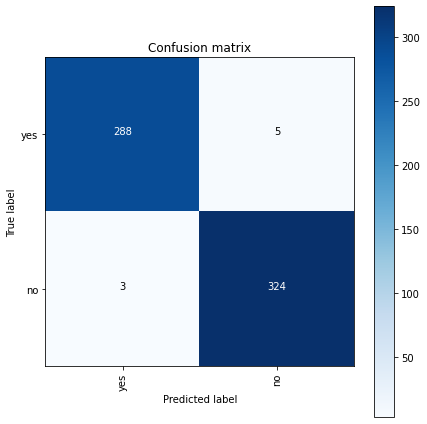

<Figure size 432x288 with 0 Axes>

In [ ]:
labels = ['yes','no']
confusion_mtx = confusion_matrix(y_test, y_pred) 
cm = plot_confusion_matrix(confusion_mtx, classes = labels, normalize=False)

In [ ]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_pred))

Confusion matrix:
[[288   5]
 [  3 324]]


In [ ]:
import pickle
# save the model to disk
filename = '/content/drive/My Drive/finalized_model.sav'
pickle.dump(clf, open(filename, 'wb'))

In [ ]:
#How to see output on new input image


In [ ]:
#read image and preprocess it
path="/content/drive/My Drive/augmented_data/no/aug_48 no._0_370.jpg"
img=cv2.imread(path)
img = crop_brain_contour(img, plot=False)
img = cv2.resize(img, dsize=(256,256), interpolation=cv2.INTER_CUBIC)
img = img / 255.
from keras.preprocessing import image
test_image = image.img_to_array(img)
test_image = np.expand_dims(test_image, axis = 0)

In [ ]:
vggmodel = load_model("/content/drive/My Drive/VGG_model.h5")

In [ ]:
#get features for input image
test_f=vggmodel.predict(test_image)


In [ ]:
#reshape features
test_f=test_f.reshape(test_f.shape[0],-1)

In [ ]:
#load svm model which is generated already
filename = '/content/drive/My Drive/finalized_model.sav' 
svm_model = pickle.load(open(filename, 'rb'))

In [ ]:
# why no detected, bcz we passed image from no folder...try givving image from yes folder also within the augmented data folder
prediction_svm=svm_model.predict(test_f)
if(prediction_svm[0]==0):
   print("No tumor detected")
else:
   print("Tumor detected")


No tumor detected
